In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
#----------------------------------------------------------------------
# Densidad superficial de masa con bines equiespaciados (en x o y)
#----------------------------------------------------------------------
def surf_density_x(x,y,m,nbin,nmin,nmax):
    
    
    mass, xedges, yedges = np.histogram2d(x, y, nbin, [[nmin,nmax],[nmin,nmax]], density=False, weights=m)
    
#     nodos  = np.concatenate([-nodos_[::-1],nodos_])
    
    sigmax = np.zeros(nbin)
    sigmay = np.zeros(nbin)
    
    widthx = np.diff(xedges)
    widthy = np.diff(yedges)
    
    medx   = xedges[:-1] + widthx/2.
    medy   = yedges[:-1] + widthy/2.
    
    middle = nbin//2
    
    for i in range(nbin):
        areax     = widthx[i]*widthy[middle]
        sigmax[i] = mass[i,middle]/areax

        areay     = widthy[i]*widthx[middle]
        sigmay[i] = mass[middle,i]/areay
    
    return sigmax, sigmay, medx, medy

### Lbar GADGET

lbar_0.15 =  1.3934955456116058
lbar_phi =  1.936027658355606
lbar_0.25 =  1.5446930196550157
lbar_perf =  2.390311814662735


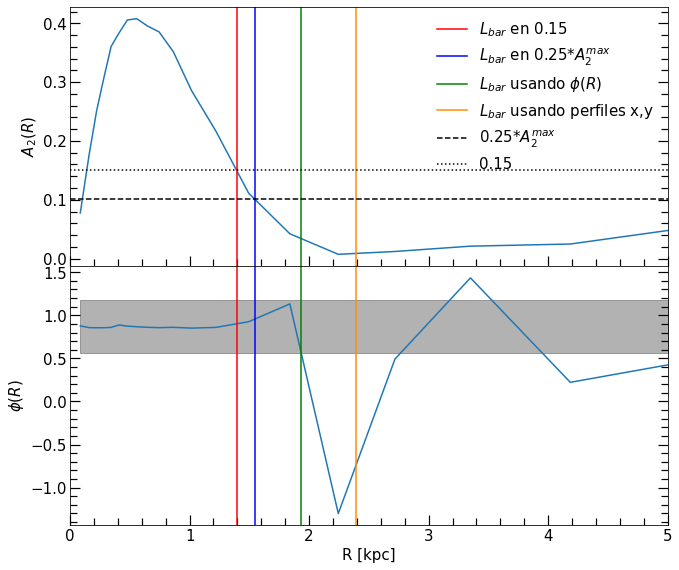

lbar_0.15 =  0.30058524012565613
lbar_phi =  2.2574986936869443
lbar_0.25 =  1.744749735902857
lbar_perf =  2.289659505987239


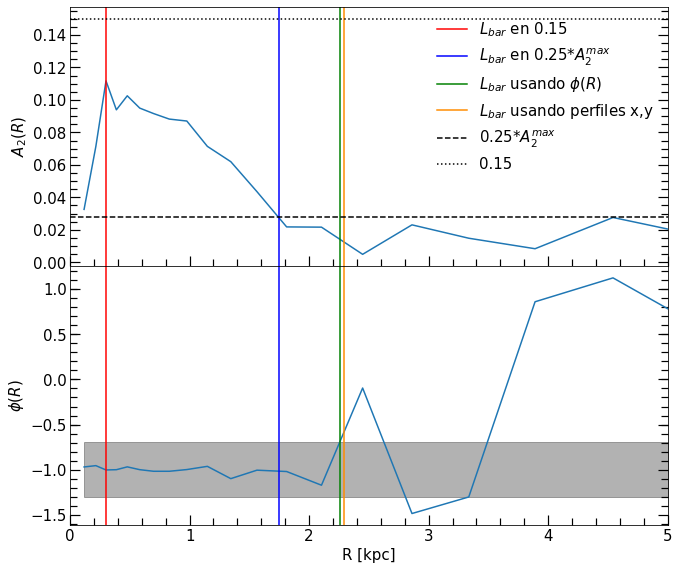

lbar_0.15 =  0.4855991005897522
lbar_phi =  1.430053342808713
lbar_0.25 =  2.0898156364162164
lbar_perf =  0.17609125905568135


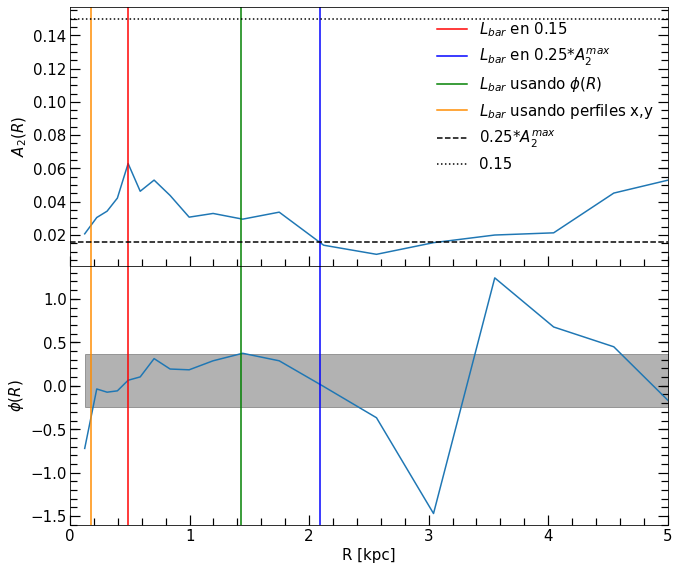

In [7]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

# for isnap in snapshot:

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
archivo = open(path2 + 'lbar_set_GD.dat','a')
       

isnap=496

halos = (0,1,3)

for i in halos:
    
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

    #paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)

    #paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    #-------------------------------------------------------------------------------------
    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3.*aexp[isnap])
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte2], xn[corte2], yn[corte2], 20)
    #     A2_2, phi, rbin2 = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)

    #---lbar 1 ----------------------------------------------------------------------
    finterp = sint.interp1d(rbin,A2)
    point = np.linspace(rmax,5,1000)

    hbar  = 0.15
    resta = finterp(point) - hbar


    mask, = np.where(resta < 0.)

    lbar = point[mask][0]

    print 'lbar_0.15 = ', lbar
    # #---lbar2---------------------------------------------------------------------------------

    phi_int = sint.interp1d(rbin,phi)
    point = np.linspace(rmax,5,1000)

    rest = np.abs(phi_int(point)-phimax)
    
#     angulo = 0.087
    angulo = 0.3
    limit, = np.where(rest>np.arcsin(angulo))

    lbar2 = point[limit][0]

    print 'lbar_phi = ', lbar2

    #---lbar 3 ----------------------------------------------------------------------
    finterp1 = sint.interp1d(rbin,A2)
    point1 = np.linspace(rmax,5,1000)

    hbar1 = 0.25*A2max
    resta1 = finterp1(point) - hbar1

    mask1, = np.where(resta1 < 0.)

    lbar3 = point1[mask1][0]
    
    print 'lbar_0.25 = ', lbar3
    
    #---lbar 4 ----------------------------------------------------------------------
    xx = xn*np.cos(phimax)  + yn*np.sin(phimax)
    yy = xn*-np.sin(phimax) + yn*np.cos(phimax)
    zz = zn
    
    R = np.sqrt(xx**2 + yy**2)
    
    corte0, = np.where(r<rgal)

    nbin = 51
    R_profile, medR = density.surf_density2(R[corte0], mstr[corte0]*1e10,nbin,0,5)
    sigmax, sigmay, medx, medy = surf_density_x(xx[corte0],yy[corte0],mstr[corte0]*1e10,nbin,-5,5)


    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    arg = diff.argmax()

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),8,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf = ', lbar4

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

    ax[0].plot(rbin,A2)
    ax[0].axvline(x=lbar,color='r', label='$L_{bar}$ en 0.15')
    ax[0].axvline(x=lbar3,color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
    ax[0].axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
    ax[0].axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
    ax[0].axhline(y=hbar1,color='k',ls='--',label='0.25*$A_2^{max}$')
    ax[0].axhline(y=0.15,color='k',ls=':',label='0.15')
    ax[0].minorticks_on()
    ax[0].tick_params( labelsize=15)
    ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[0].set_ylabel('$A_{2}(R)$',fontsize=15)
    ax[0].set_xlim(0,5)
    ax[0].legend(fontsize=15,frameon=False)

    line1 = phimax + np.arcsin(angulo)
    line2 = phimax - np.arcsin(angulo)
    ax[1].plot(rbin,phi)
    ax[1].axvline(x=lbar,color='r')
    ax[1].axvline(x=lbar3,color='b')
    ax[1].fill_between(rbin,line2,line1,color='k',alpha=0.3)
    ax[1].axvline(x=lbar2,color='g')
    ax[1].axvline(x=lbar4,color='darkorange')
    ax[1].minorticks_on()
    ax[1].tick_params( labelsize=15)
    ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[1].set_ylabel('$\phi(R)$',fontsize=15)
    ax[1].set_xlabel('R [kpc]',fontsize=15)
    
    plt.show()
    
    archivo.write(str('%s'%i) +'\t'+
                   str('%12.8f'% lbar) +'\t'+
                   str('%12.8f'% lbar2) +'\t'+
                   str('%12.8f'% lbar3) +'\t'+
                   str('%12.8f'% lbar4) +'\n')
archivo.close()
    
#lbarvstime2.dat usa la interpolacion de interp1d

lbar_0.15 =  0.8581089395465273
lbar_phi =  1.3638803998271265
lbar_0.25 =  0.9266537485179958
lbar_perf =  1.2138403223411545


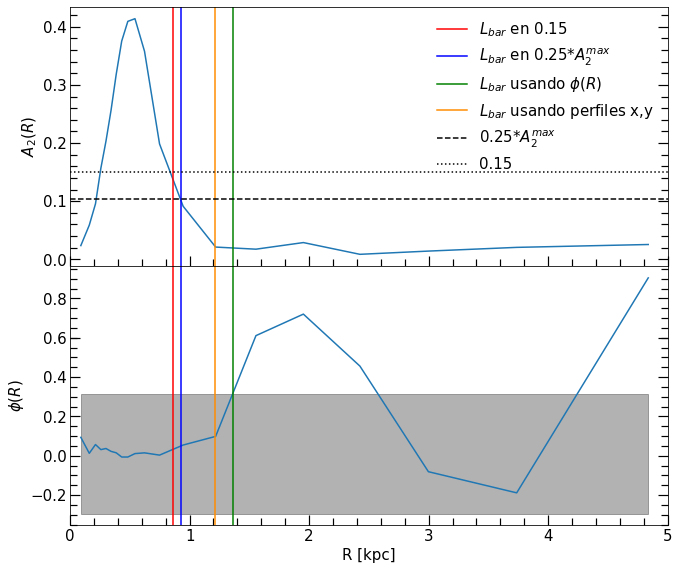

lbar_0.15 =  1.3086832382462241
lbar_phi =  3.1077434150902956
lbar_0.25 =  1.4503253562314375
lbar_perf =  3.095122561408321


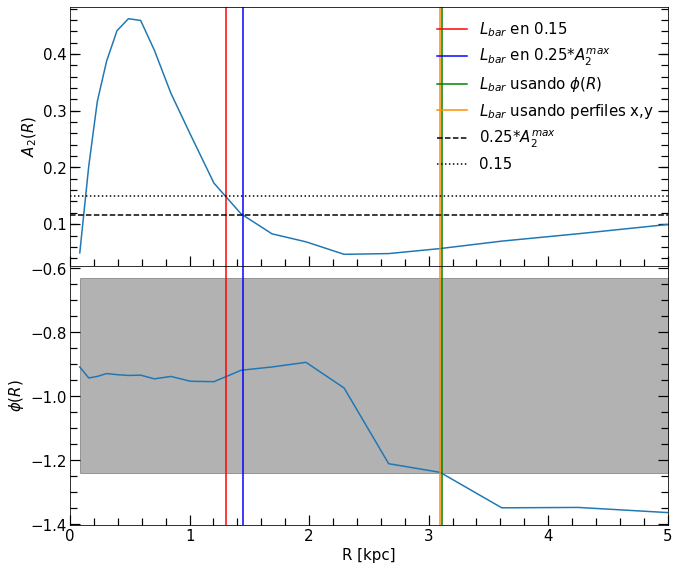

lbar_0.15 =  0.5115792155265808
lbar_phi =  2.6232486536672286
lbar_0.25 =  2.4165746235513357
lbar_perf =  0.7945179947573192


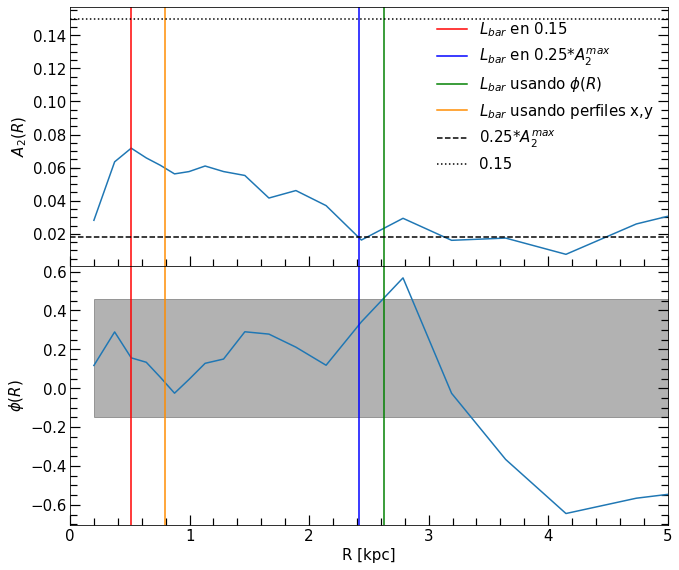

In [8]:
import h5py
import rotation_mio as rot
import barstrength2 as strng
import scipy.interpolate as sint
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]


path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
archivo = open(path2 + 'lbar_set_GS.dat','a')


# for j in range(len(snapshot)-1,32,-1):
j=0
#     path = '/home/ornela/SimCLUES/'



halos = (1,2,4)

for i in halos:  
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    #-----------------------------------------------------------------------------------

    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3*aexp)
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte2], xn[corte2], yn[corte2], 20)


    #---lbar 1 ----------------------------------------------------------------------
    finterp = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point = np.linspace(rmax,5,100)

    hbar  = 0.15
    resta = finterp(point) - hbar

    mask, = np.where(resta < 0.)

    lbar = point[mask][0]

    print 'lbar_0.15 = ', lbar
    # #---lbar2---------------------------------------------------------------------------------

    phi_int = sint.interp1d(rbin,phi,fill_value="extrapolate")
    point = np.linspace(rmax,5,1000)

#     angulo=0.087
    angulo=0.3
    rest = np.abs(phi_int(point)-phimax)
    limit, = np.where(rest>np.arcsin(angulo))

    lbar2 = point[limit][0]

    print 'lbar_phi = ', lbar2

    #---lbar 3 ----------------------------------------------------------------------
    finterp1 = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point1 = np.linspace(rmax,5,1000)

    hbar1 = 0.25*A2max
    resta1 = finterp1(point) - hbar1

    mask1, = np.where(resta1 < 0.)

    lbar3 = point1[mask1][0]
    
    print 'lbar_0.25 = ', lbar3
    
    #---lbar 4 ----------------------------------------------------------------------
    xx = xn*np.cos(phimax)  + yn*np.sin(phimax)
    yy = xn*-np.sin(phimax) + yn*np.cos(phimax)
    zz = zn
    
    R = np.sqrt(xx**2 + yy**2)
    
    corte0, = np.where(r<rgal)

    nbin = 51
    R_profile, medR = density.surf_density2(R[corte0], mstr[corte0]*1e10,nbin,0,5)
    sigmax, sigmay, medx, medy = surf_density_x(xx[corte0],yy[corte0],mstr[corte0]*1e10,nbin,-5,5)


    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    arg = diff.argmax()

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),8,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf = ', lbar4
    

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

    ax[0].plot(rbin,A2)
    ax[0].axvline(x=lbar,color='r', label='$L_{bar}$ en 0.15')
    ax[0].axvline(x=lbar3,color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
    ax[0].axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
    ax[0].axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
    ax[0].axhline(y=hbar1,color='k',ls='--',label='0.25*$A_2^{max}$')
    ax[0].axhline(y=0.15,color='k',ls=':',label='0.15')
    ax[0].minorticks_on()
    ax[0].tick_params( labelsize=15)
    ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[0].set_ylabel('$A_{2}(R)$',fontsize=15)
    ax[0].set_xlim(0,5)
    ax[0].legend(fontsize=15,frameon=False)

    line1 = phimax + np.arcsin(angulo)
    line2 = phimax - np.arcsin(angulo)
    ax[1].plot(rbin,phi)
    ax[1].axvline(x=lbar,color='r')
    ax[1].axvline(x=lbar3,color='b')
    ax[1].fill_between(rbin,line2,line1,color='k',alpha=0.3)
    ax[1].axvline(x=lbar2,color='g')
    ax[1].axvline(x=lbar4,color='darkorange')
    ax[1].minorticks_on()
    ax[1].tick_params( labelsize=15)
    ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[1].set_ylabel('$\phi(R)$',fontsize=15)
    ax[1].set_xlabel('R [kpc]',fontsize=15)
    
    plt.show()

    archivo.write(str('%s'%i) +'\t'+
                   str('%12.8f'% lbar) +'\t'+
                   str('%12.8f'% lbar2) +'\t'+
                   str('%12.8f'% lbar3) +'\t'+
                   str('%12.8f'% lbar4) +'\n')
archivo.close()